
=== Model Selection (Cross-Validated R²) ===

RandomForest       → R² = -0.004
GradientBoosting   → R² = -0.724

 Best Model Selected: RandomForest

=== Final Test Evaluation ===
R² Score       : -0.036
MAE (minutes)  : 5.014
RMSE (minutes) : 5.974



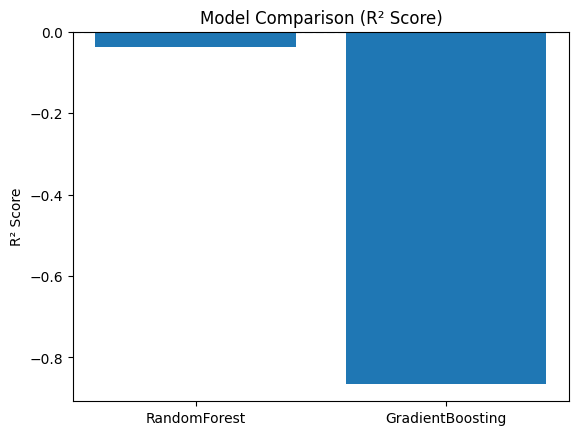

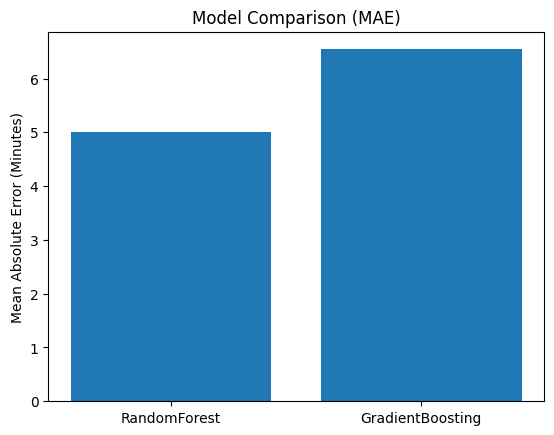

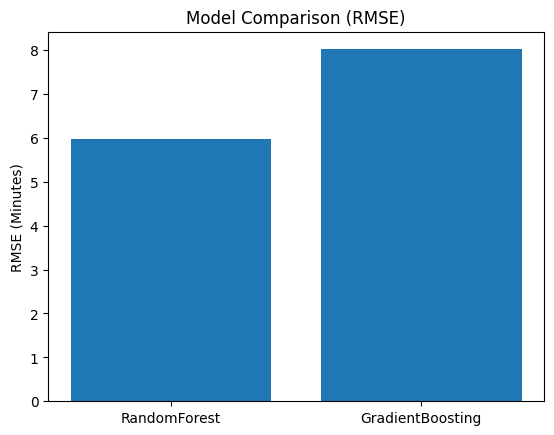


 Top Influential Features:

                              Feature  Importance
25                     Drift_Category    0.106126
0                                Date    0.088225
24  Focus_Session_Length_Before_Drift    0.086178
22                Productivity_Impact    0.065834
9                  Distraction_Source    0.059479
23     Cumulative_Drift_Today_Minutes    0.056317
8                    Specific_Trigger    0.049783
18                Temperature_Comfort    0.049443
2                            End_Time    0.047341
1                          Start_Time    0.044983 



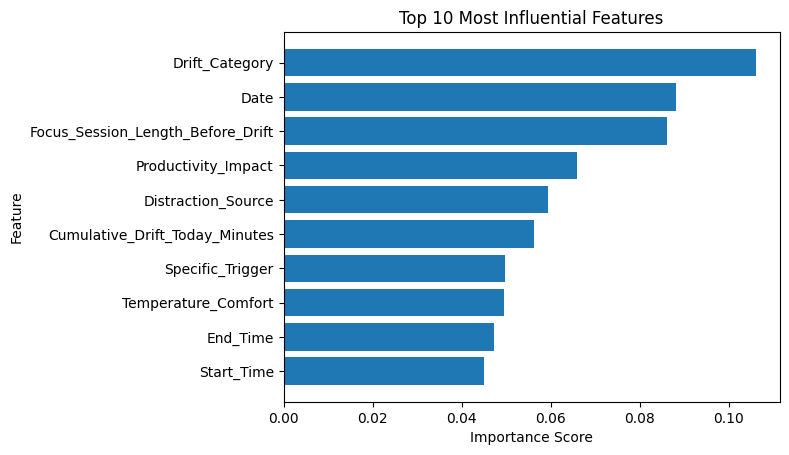

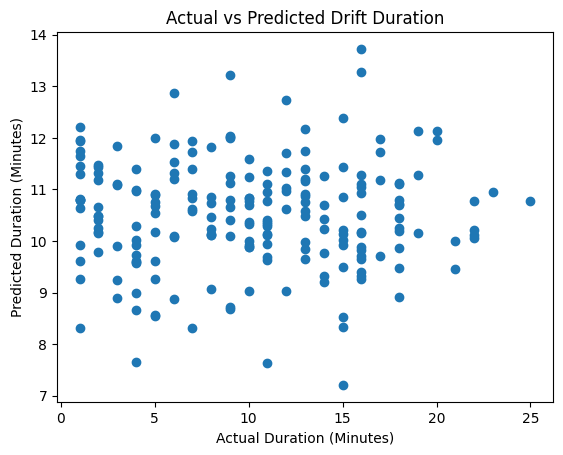

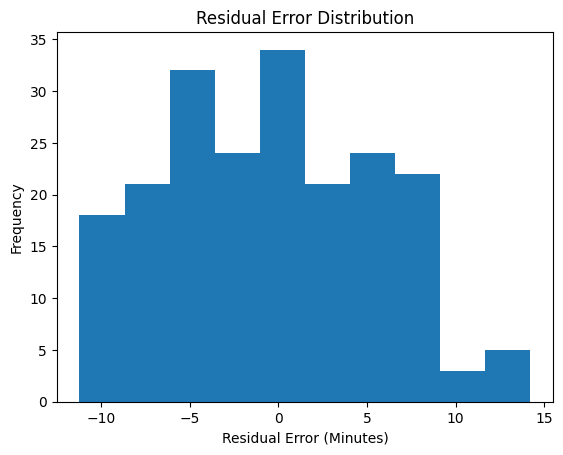


=== Predict Drift Duration (Key Inputs Only) ===



In [ ]:
#CASE STUDY

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


df = pd.read_csv("attention_drift_dataset_extended_plus600_corrected_v2.csv", encoding="latin1")

if "Drift_ID" in df.columns:
    df = df.drop(columns=["Drift_ID"])

df = df.rename(columns={"Caffeine/Meal_Status": "Caffeine_Meal_Status"})

TARGET = "Duration_Minutes"
df = df.dropna(subset=[TARGET])

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)



X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_cols = X_train_raw.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = [c for c in X_train_raw.columns if c not in cat_cols]



def make_trees_preprocessor():
    return ColumnTransformer(
        transformers=[
            ("cat", Pipeline([
                ("impute", SimpleImputer(strategy="most_frequent")),
                ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
            ]), cat_cols),

            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")),
            ]), num_cols),
        ]
    )



models = {
    "RandomForest": Pipeline([
        ("prep", make_trees_preprocessor()),
        ("mdl", RandomForestRegressor(n_estimators=300, max_depth=10,
                                      min_samples_split=5, min_samples_leaf=2,
                                      random_state=42, n_jobs=-1))
    ]),
    "GradientBoosting": Pipeline([
        ("prep", make_trees_preprocessor()),
        ("mdl", GradientBoostingRegressor(n_estimators=200, max_depth=5,
                                          learning_rate=0.1, random_state=42))
    ])
}


print("\n=== Model Selection (Cross-Validated R²) ===\n")
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = {}

for name, pipe in models.items():
    score = cross_val_score(pipe, X_train_raw, y_train, scoring="r2", cv=cv).mean()
    cv_scores[name] = score
    print(f"{name:<18} → R² = {score:.3f}")

best_model_name = max(cv_scores, key=cv_scores.get)
best_model = models[best_model_name]
print(f"\n Best Model Selected: {best_model_name}\n")


best_model.fit(X_train_raw, y_train)
y_pred = best_model.predict(X_test_raw)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("=== Final Test Evaluation ===")
print(f"R² Score       : {r2:.3f}")
print(f"MAE (minutes)  : {mae:.3f}")
print(f"RMSE (minutes) : {rmse:.3f}\n")



model_names = list(models.keys())
test_r2_list, test_mae_list, test_rmse_list = [], [], []

for name, pipe in models.items():
    pipe.fit(X_train_raw, y_train)
    preds = pipe.predict(X_test_raw)
    test_r2_list.append(r2_score(y_test, preds))
    test_mae_list.append(mean_absolute_error(y_test, preds))
    test_rmse_list.append(np.sqrt(mean_squared_error(y_test, preds)))

# R² Chart
plt.figure()
plt.bar(model_names, test_r2_list)
plt.ylabel("R² Score")
plt.title("Model Comparison (R² Score)")
plt.axhline(0, linestyle="--")
plt.show()

# MAE Chart
plt.figure()
plt.bar(model_names, test_mae_list)
plt.ylabel("Mean Absolute Error (Minutes)")
plt.title("Model Comparison (MAE)")
plt.show()

# RMSE Chart
plt.figure()
plt.bar(model_names, test_rmse_list)
plt.ylabel("RMSE (Minutes)")
plt.title("Model Comparison (RMSE)")
plt.show()



mdl = best_model.named_steps["mdl"]

if hasattr(mdl, "feature_importances_"):
    importance = mdl.feature_importances_
    feature_names = list(X_train_raw.columns)
    feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importance})
    feat_imp = feat_imp.sort_values("Importance", ascending=False)

    print("\n Top Influential Features:\n")
    print(feat_imp.head(10), "\n")

    plt.figure()
    plt.barh(feat_imp["Feature"].head(10), feat_imp["Importance"].head(10))
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title("Top 10 Most Influential Features")
    plt.gca().invert_yaxis()
    plt.show()


plt.figure()
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Duration (Minutes)")
plt.ylabel("Predicted Duration (Minutes)")
plt.title("Actual vs Predicted Drift Duration")
plt.show()

plt.figure()
residuals = y_test - y_pred
plt.hist(residuals)
plt.xlabel("Residual Error (Minutes)")
plt.ylabel("Frequency")
plt.title("Residual Error Distribution")
plt.show()



top_features = [
    "Drift_Category",
    "Focus_Session_Length_Before_Drift",
    "Productivity_Impact",
    "Distraction_Source",
    "Specific_Trigger",
    "Temperature_Comfort"
]

def predict_from_user_input():
    print("\n=== Predict Drift Duration (Key Inputs Only) ===\n")
    user_data = {}

    for col in top_features:
        default = (
            round(X_train_raw[col].median(), 2)
            if col in num_cols else X_train_raw[col].mode().iloc[0]
        )
        value = input(f"{col} (default = {default}): ").strip()
        user_data[col] = float(value) if (value and col in num_cols) else value or default

    for col in X_train_raw.columns:
        if col not in user_data:
            user_data[col] = (
                round(X_train_raw[col].median(), 2)
                if col in num_cols else X_train_raw[col].mode().iloc[0]
            )

    pred = best_model.predict(pd.DataFrame([user_data]))[0]
    print(f"\n Predicted Drift Duration → {pred:.2f} minutes\n")

predict_from_user_input()
